# Choroid Plexus Segmentation Training via Auto3DSeg

In [9]:
import os
import json
import nibabel as nib
import nibabel as nibabel
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import random
from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from mri_preproc.paths import hemond_data, init_paths
import importlib
from dataclasses import asdict

print_config()

MONAI version: 1.3.3rc1+7.g2e53df78
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2e53df78e580131046dc8db7f7638063db1f5045
MONAI __file__: /home/<username>/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.43.3
mlflow version: 2.15.0
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [10]:
init_paths.main()
from mri_preproc.paths.init_paths import DATA_HOME

importlib.reload(hemond_data)

<module 'mri_preproc.paths.hemond_data' from '/home/srs-9/Projects/ms_mri/mri_preproc/paths/hemond_data.py'>

## Prep the database

Get the data and labels organized

In [11]:
dataset0 = hemond_data.collect_proc_dataset("/mnt/t/Data/3Tpioneer_bids")
dataset_ref = hemond_data.scan_data_dir("/mnt/t/Data/MONAI/flair")

dataset = hemond_data.DataSet("DataSet", hemond_data.Scan)
for ref_data in dataset_ref:
    scan = dataset0.find_scan(ref_data.subid, ref_data.date)
    if scan:
        dataset.append(asdict(scan))

No scan exists for subject: ms1492 and session: 20190620


Which scans have no label

In [12]:
for data in dataset:
    if data.label is None:
        print(data.subid, data.date)

ms1022 20190807
ms1053 20161218
ms1128 20161029
ms1491 20190606


In [13]:
dataset = dataset[1:]
dataset = hemond_data.assign_conditions(dataset)
dataset[0]

Scan(subid='ms1002', date='20200521', root=PosixPath('/mnt/t/Data/3Tpioneer_bids/sub-ms1002/ses-20200521'), image=PosixPath('/mnt/t/Data/3Tpioneer_bids/sub-ms1002/ses-20200521/proc/flair-brain-mni_reg.nii.gz'), label=PosixPath('/mnt/t/Data/3Tpioneer_bids/sub-ms1002/ses-20200521/proc/lesion_index.t3m20-mni_reg-mask.nii.gz'), cond='tr')

In [14]:
training_data = []
test_data = []

for scan in dataset:
    if scan.cond == 'tr':
        training_data.append({"image": scan.image, "label": scan.label})
    elif scan.cond == 'ts':
        test_data.append(scan.image)

## Review

In [15]:
def display_slices(scan):
    img1 = nibabel.load(scan.image)
    img2 = nibabel.load(scan.label)

    data1 = img1.get_fdata()[:,:,:]
    data2 = img2.get_fdata()

    slice_sums = np.sum(data2, axis=(0, 1))
    
    print(slice_sums)

    max_slice_index = np.argmax(slice_sums)
    print(f"Max slice: {max_slice_index}")

    slice1 = data1[:, :, max_slice_index]
    slice2 = data2[:, :, max_slice_index]    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(slice1, cmap='gray')
    plt.title(f"Image 1 - Slice {max_slice_index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(slice2, cmap='gray')
    plt.title(f"Image 2 - Slice {max_slice_index}")
    plt.axis('off')
    plt.show()


In [16]:
img2 = nibabel.load(dataset[0].label)
data2 = img2.get_fdata()

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   5.  28.  54.  77.  94. 111. 143.
 182. 264. 322. 359. 363. 359. 353. 340. 320. 334. 338. 330. 324. 354.
 373. 389. 405. 432. 439. 465. 461. 417. 368. 279. 224. 212. 201. 183.
 136.  73.  13.   0.  14.  18.  34.  33.  32.  22.  20.  10.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Max slice: 89


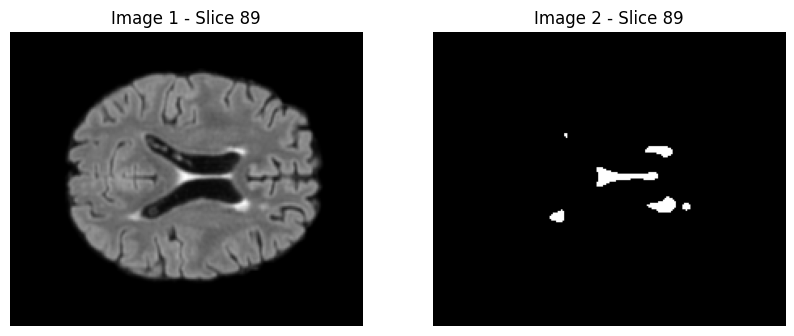

In [17]:
display_slices(dataset[20])

In the original code, they include labels in the test data as well. Also they have a function that checks that there is nonzero number of voxels in the label

In [18]:
#? I don't know why they put labels for the test data. the brats segmentation code didn't.
# train_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in train_exams]
# test_data = [{'image': path + '/flair.nii.gz', 'label': path + '/flair_chp_mask_qced.nii.gz'} for path in test_exams]

train_data = []
test_data = []
for scan in dataset:
    if scan.cond == 'tr' and scan.has_label:
        train_data.append({"image": str(scan.image), "label": str(scan.label)})
    elif scan.cond == 'ts' and scan.has_label():
        test_data.append({"image": str(scan.image), "label": str(scan.label)})


print(f"Train num total: {len(train_data)}")
print(f"Test num: {len(test_data)}")

Train num total: 320
Test num: 31


In [21]:
n_folds = 5
datalist = {
    "testing": test_data,
    "training": [{"fold": i % n_folds, "image": c["image"], "label": c["label"]} for i,c in enumerate(train_data)]
}

In [22]:
# sub_datalist = dict({'training':[], 'testing':[]})
# sub_datalist["training"] = datalist["training"][:100]
# sub_datalist["testing"] = datalist["testing"][:29]
# datalist = sub_datalist

In [23]:
datalist

{'testing': [{'image': '/mnt/t/Data/3Tpioneer_bids/sub-ms1011/ses-20180911/proc/flair-brain-mni_reg.nii.gz',
   'label': '/mnt/t/Data/3Tpioneer_bids/sub-ms1011/ses-20180911/proc/lesion_index.t3m20-mni_reg-mask.nii.gz'},
  {'image': '/mnt/t/Data/3Tpioneer_bids/sub-ms1016/ses-20200421/proc/flair-brain-mni_reg.nii.gz',
   'label': '/mnt/t/Data/3Tpioneer_bids/sub-ms1016/ses-20200421/proc/lesion_index.t3m20-mni_reg-mask.nii.gz'},
  {'image': '/mnt/t/Data/3Tpioneer_bids/sub-ms1050/ses-20170624/proc/flair-brain-mni_reg.nii.gz',
   'label': '/mnt/t/Data/3Tpioneer_bids/sub-ms1050/ses-20170624/proc/lesion_index.t3m20-mni_reg-mask.nii.gz'},
  {'image': '/mnt/t/Data/3Tpioneer_bids/sub-ms1063/ses-20161017/proc/flair-brain-mni_reg.nii.gz',
   'label': '/mnt/t/Data/3Tpioneer_bids/sub-ms1063/ses-20161017/proc/lesion_index.t3m20-mni_reg-mask.nii.gz'},
  {'image': '/mnt/t/Data/3Tpioneer_bids/sub-ms1066/ses-20180828/proc/flair-brain-mni_reg.nii.gz',
   'label': '/mnt/t/Data/3Tpioneer_bids/sub-ms1066/ses-

In [24]:
len(datalist['training'])

320

In [25]:
work_dir = "/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22"
# work_dir = "/home/hemondlab/Dev/ms_mri/training_work_dirs/cp_work_dir6"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = DATA_HOME
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "datalist.json")
with open(datalist_file, "w") as f:
    json.dump(datalist, f)

In [26]:
runner = AutoRunner(
    work_dir=work_dir,
    algos=["swinunetr"],
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    },
)

2024-08-01 18:20:44,580 - INFO - AutoRunner using work directory /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22
2024-08-01 18:20:44,582 - INFO - Found num_fold 5 based on the input datalist /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/datalist.json.
2024-08-01 18:20:44,583 - INFO - Setting num_fold 5 based on the input datalist /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/datalist.json.
2024-08-01 18:20:44,602 - INFO - Using user defined command running prefix , will override other settings


In [27]:
max_epochs = 100

train_param = {
    "num_epochs_per_validation": 1,
    #"num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)

In [28]:
runner.run()

2024-08-01 18:20:44,617 - INFO - Running data analysis...
2024-08-01 18:20:44,618 - INFO - Found 1 GPUs for data analyzing!


100%|██████████| 320/320 [00:48<00:00,  6.65it/s]


2024-08-01 18:21:33,045 - INFO - Writing data stats to /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/datastats.yaml.
2024-08-01 18:21:33,051 - INFO - Writing by-case data stats to /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/datastats_by_case.yaml, this may take a while.
2024-08-01 18:21:33,724 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/e4cf5a1.tar.gz


algo_templates.tar.gz: 104kB [00:00, 225kB/s]                              

2024-08-01 18:21:34,201 - INFO - Downloaded: /tmp/tmpctq5nshj/algo_templates.tar.gz
2024-08-01 18:21:34,202 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpctq5nshj/algo_templates.tar.gz.
2024-08-01 18:21:34,202 - INFO - Writing into directory: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22.
2024-08-01 18:21:34,257 - INFO - Generated:/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0
2024-08-01 18:21:34,288 - INFO - Generated:/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1
2024-08-01 18:21:34,321 - INFO - Generated:/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2
2024-08-01 18:21:34,352 - INFO - Generated:/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3


2024-08-01 18:21:34,385 - INFO - Generated:/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4
2024-08-01 18:21:34,420 - INFO - ['python', '/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/scripts/train.py', 'run', "--config_file='/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/configs/hyper_parameters.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/configs/network.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/configs/transforms_infer.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/configs/transforms_train.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


2024-08-01 18:22:05,858 - INFO - Downloaded: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-08-01 18:22:05,858 - INFO - Expected md5 is None, skip md5 check for file /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
2024/08/01 18:22:06 INFO mlflow.

2024-08-02 03:15:10,933 - INFO - ['python', '/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/scripts/train.py', 'run', "--config_file='/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/configs/hyper_parameters.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/configs/network.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/configs/transforms_infer.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/configs/transforms_train.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


2024-08-02 03:15:41,112 - INFO - Downloaded: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-08-02 03:15:41,112 - INFO - Expected md5 is None, skip md5 check for file /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_1/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
2024/08/02 03:15:41 INFO mlflow.

2024-08-02 09:25:12,576 - INFO - ['python', '/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/scripts/train.py', 'run', "--config_file='/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/configs/hyper_parameters.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/configs/network.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/configs/transforms_infer.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/configs/transforms_train.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


2024-08-02 09:25:40,908 - INFO - Downloaded: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-08-02 09:25:40,909 - INFO - Expected md5 is None, skip md5 check for file /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_2/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
2024/08/02 09:25:41 INFO mlflow.

2024-08-02 15:42:48,255 - INFO - ['python', '/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/scripts/train.py', 'run', "--config_file='/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/configs/hyper_parameters.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/configs/network.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/configs/transforms_infer.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/configs/transforms_train.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


2024-08-02 15:43:16,424 - INFO - Downloaded: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-08-02 15:43:16,424 - INFO - Expected md5 is None, skip md5 check for file /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_3/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
2024/08/02 15:43:16 INFO mlflow.

2024-08-02 22:00:02,057 - INFO - ['python', '/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/scripts/train.py', 'run', "--config_file='/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/configs/hyper_parameters.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/configs/network.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/configs/transforms_infer.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/configs/transforms_train.yaml,/home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_epochs=100', '--num_warmup_epochs=1']


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


2024-08-02 22:00:32,733 - INFO - Downloaded: /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2024-08-02 22:00:32,734 - INFO - Expected md5 is None, skip md5 check for file /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/swinunetr_4/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
2024/08/02 22:00:33 INFO mlflow.

2024-08-03 04:09:17,923 - INFO - Ensembling using single GPU!
2024-08-03 04:09:17,924 - INFO - The output_dir is not specified. /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/ensemble_output will be used to save ensemble predictions.
2024-08-03 04:09:17,926 - INFO - Directory /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/ensemble_output is created to save ensemble predictions
2024-08-03 04:09:17,975 - INFO - Auto3Dseg picked the following networks to ensemble:
2024-08-03 04:09:17,975 - INFO - swinunetr_0
2024-08-03 04:09:17,976 - INFO - swinunetr_1
2024-08-03 04:09:17,976 - INFO - swinunetr_2
2024-08-03 04:09:17,977 - INFO - swinunetr_3
2024-08-03 04:09:17,977 - INFO - swinunetr_4
2024-08-03 04:09:17,978 - INFO - Auto3Dseg ensemble prediction outputs will be saved in /home/srs-9/Projects/ms_mri/training_work_dirs/cp_work_dir22/ensemble_output.


Ensembling (rank 0)...:   0%|          | 0/31 [00:00<?, ?it/s]monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `w

In [29]:
scan_path = "/mnt/t/Data/3Tpioneer_bids/sub-ms1001/ses-20170215/proc/lesion_index.t3m20-mni_reg.nii.gz"
img = nib.load(scan_path)
